# 1

#### En el ejemplo de teoría hemos visto la forma de entrenar utilizando un trozo de datos como en la imagen "way1.png". 

(Básicamente, tener en cuenta más datos de entrenamiento, 20% de test)

Investiga la forma de realizar el ejercicio a partir del gif "way3_sliding_window.gif":

- ¿Da mejores resultados entrenar el modelo así?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback

In [2]:
# Total time points
N = 3000
# Time point to partition train/test splits
Tp = 2250  

t = np.arange(0,N)
x = (2*np.sin(0.02*t)*np.sin(0.003*t))+0.5*np.random.normal(size=N)
df = pd.DataFrame(x, columns=['Data'])
len(df)

3000

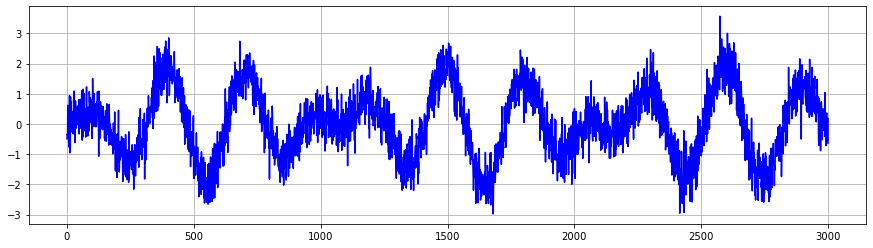

In [3]:
plt.figure(figsize=(15,4))
plt.plot(df, c='blue')
plt.grid(True)
plt.show()

### Split the values in train and test

So, we took 80% of the data as training samples and set aside the rest of the data for testing. 

Looking at the time-series plot, we think **it is not easy for a standard model to come up with correct trend predictions.**

In [4]:
values = df.values
train, test = values[0:Tp ,:], values[Tp:N,:]

In [5]:
print("Train data length:", train.shape)
print("Test data length:", test.shape)

Train data length: (2250, 1)
Test data length: (750, 1)


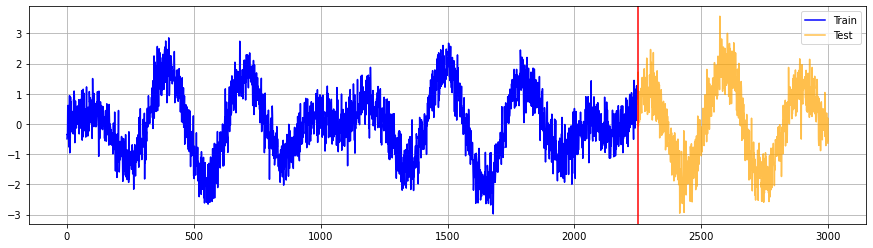

In [6]:
index = df.index.values
plt.figure(figsize=(15,4))
plt.plot(index[0:Tp],train,c='blue')
plt.plot(index[Tp:N],test,c='orange',alpha=0.7)
plt.legend(['Train','Test'])
plt.axvline(df.index[Tp], c="r")
plt.grid(True)
plt.show()

### Step (or _embedding_)
RNN model requires a step value that contains n number of elements as an input sequence.

Suppose x = {1,2,3,4,5,6,7,8,9,10}

for step=1, x input  and its y prediction become:

| x  | y  |
|---|---|
| 1  | 2  |
| 2  | 3  |
| 3  | 4  |
| ...  | ...  |
| 9  | 10  |

for step=3, x and y contain:

| x  | y  |
|---|---|
| 1,2,3  | 4  |
| 2,3,4  | 5  |
| 3,4,5  | 6  |
| ...  | ...  |
| 7,8,9  | 10  |

Here, we choose `step=4`. In more complex RNN and in particular for text processing, this is also called _embedding size_.

In [7]:
train.shape

(2250, 1)

In [8]:
step = 4
np.append(train,np.repeat(train[-1,],step)).shape

(2254,)

In [9]:
train[-1,]

array([1.08312685])

In [10]:
train[-8:]

array([[0.96499187],
       [0.11573999],
       [0.88948364],
       [1.26583284],
       [0.8746753 ],
       [0.8793841 ],
       [0.82782793],
       [1.08312685]])

In [11]:
step = 4

# add step elements into train and test
test = np.append(test, np.repeat(test[-1,],step))
train = np.append(train, np.repeat(train[-1,],step))

In [12]:
train[-8:]

array([0.8746753 , 0.8793841 , 0.82782793, 1.08312685, 1.08312685,
       1.08312685, 1.08312685, 1.08312685])

In [13]:
print("Train data length:", train.shape)
print("Test data length:", test.shape)

Train data length: (2254,)
Test data length: (754,)


### Converting to a multi-dimensional array
Next, we'll convert test and train data into the matrix with step value as it has shown above example.

In [14]:
def convertToMatrix(data, step):
    X, Y =[], []
    for i in range(len(data)-step):
        d=i+step  
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)

In [15]:
trainX,trainY = convertToMatrix(train,step)
testX,testY = convertToMatrix(test,step)

trainX.shape

(2250, 4)

2250 trozos de 4 valores

In [16]:
trainX[0]

array([-0.49092404, -0.33639773, -0.36546272,  0.59354826])

In [17]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [18]:
trainX.shape ,  testX.shape

((2250, 1, 4), (750, 1, 4))

Para entrenar el modelo, necesito que los datos tengan la siguiente dimensión:

(2250, 1, 4)

- 2250: el número total de trozos 
- 1: una fila de datos
- 4: cada trozo tiene cuatro valores

En el caso de una imagen, recordemos con un ejemplo: 

(750, 28, 28)

750 imágenes de resolución 28x28

In [20]:
print("Training data shape:", trainX.shape,', ',trainY.shape)
print("Test data shape:", testX.shape,', ',testY.shape)

Training data shape: (2250, 1, 4) ,  (2250,)
Test data shape: (750, 1, 4) ,  (750,)


### Keras model with `SimpleRNN` layer

- 256 neurons in the RNN layer
- 32 denurons in the densely connected layer
- a single neuron for the output layer
- ReLu activation
- learning rate: 0.001

In [21]:
def build_simple_rnn(num_units=128, embedding=4, num_dense=32,lr=0.001):
    """
    Builds and compiles a simple RNN model
    Arguments:
              num_units: Number of units of a the simple RNN layer
              embedding: Embedding length - Steps - Tamaño de ventana
              num_dense: Number of neurons in the dense layer followed by the RNN layer
              lr: Learning rate (uses RMSprop optimizer)
    Returns:
              A compiled Keras model.
    """
    model = Sequential()
    model.add(SimpleRNN(units=num_units, input_shape=(1, embedding), activation="relu"))
    model.add(Dense(num_dense, activation="relu"))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=RMSprop(lr=lr),metrics=['mse'])
    
    return model

In [22]:
model = build_simple_rnn() # Taking the defaults


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 128)               17024     
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 21,185
Trainable params: 21,185
Non-trainable params: 0
_________________________________________________________________


### A simple callback class to show a message every 50 epochs

In [24]:
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % 50 == 0 and epoch>0:
            print("Epoch number {} done".format(epoch+1))

### Fit the model

Con batch_size = 16 lo que haríamos es que cogemos los datos de esta forma:

- (2250, 16, 4)

Cogemos 16 filas con 4 datos

In [25]:
batch_size=16
num_epochs = 1000

In [26]:
model.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size, 
          callbacks=[MyCallback()],verbose=0)

Epoch number 50 done
Epoch number 100 done
Epoch number 150 done
Epoch number 200 done
Epoch number 250 done
Epoch number 300 done
Epoch number 350 done
Epoch number 400 done
Epoch number 450 done
Epoch number 500 done
Epoch number 550 done
Epoch number 600 done
Epoch number 650 done
Epoch number 700 done
Epoch number 750 done
Epoch number 800 done
Epoch number 850 done
Epoch number 900 done
Epoch number 950 done
Epoch number 1000 done


### Plot loss

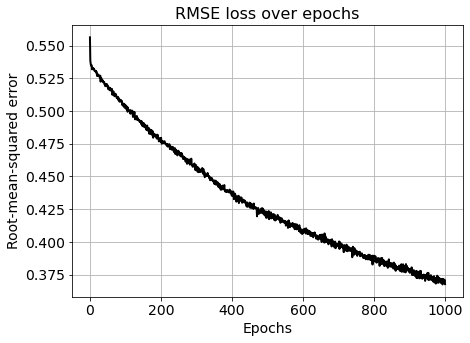

In [27]:
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model.history.history['loss']),c='k',lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Predictions
Note that the model was fitted only with the `trainX` and `trainY` data. 

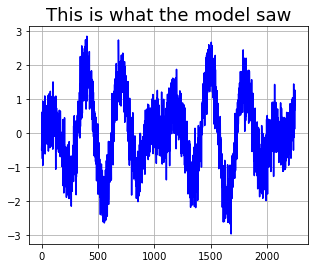

In [28]:
plt.figure(figsize=(5,4))
plt.title("This is what the model saw",fontsize=18)
plt.plot(trainX[:,0][:,0],c='blue')
plt.grid(True)
plt.show()

In [29]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# predicted contiene todo el conjunto de datos predicho por nuestro modelo 
predicted = np.concatenate((trainPredict,testPredict),axis=0)

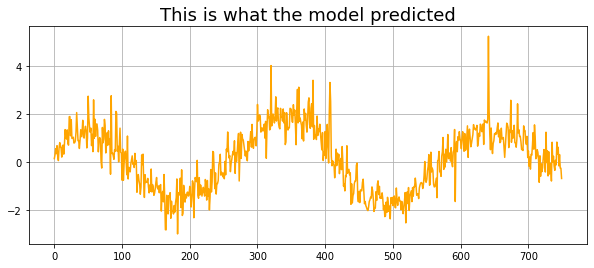

In [30]:
plt.figure(figsize=(10,4))
plt.title("This is what the model predicted",fontsize=18)
plt.plot(testPredict,c='orange')
plt.grid(True)
plt.show()

### Comparing it with the ground truth (test set)

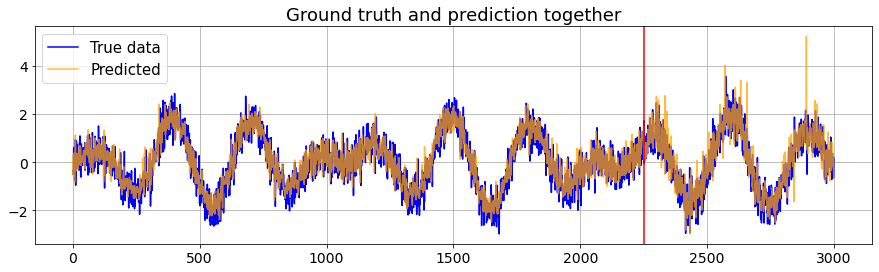

In [31]:
index = df.index.values
plt.figure(figsize=(15,4))
plt.title("Ground truth and prediction together",fontsize=18)
plt.plot(index,df,c='blue')
plt.plot(index,predicted,c='orange',alpha=0.75)
plt.legend(['True data','Predicted'],fontsize=15)
plt.axvline(df.index[Tp], c="r")
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### How are the errors distributed?
The errors, or residuals, as they are called in a regression problem, can be plotted to see if they follow any specific distribution. In the generation process, we injected Gaussian noise, so we expect the error to follow the same pattern, _if the model has been able to fit to the real data correctly_.

In [32]:
error = predicted[Tp:N]-df[Tp:N]
error = np.array(error).ravel()

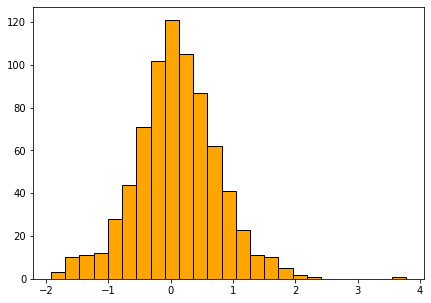

In [33]:
plt.figure(figsize=(7,5))
plt.hist(error,bins=25,edgecolor='k',color='orange')
plt.show()

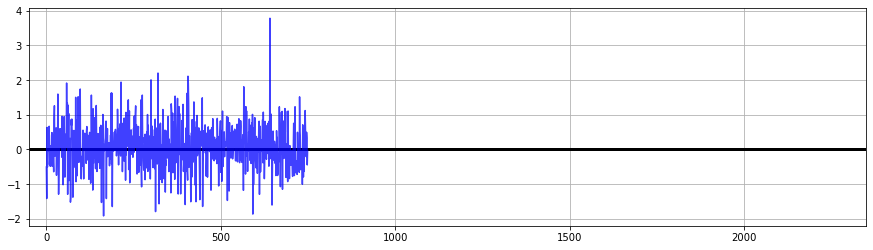

In [34]:
plt.figure(figsize=(15,4))
plt.plot(error,c='blue',alpha=0.75)
plt.hlines(y=0,xmin=-50,xmax=2400,color='k',lw=3)
plt.xlim(-50,2350)
plt.grid(True)
plt.show()

## Make the model better

Note, for running these experiments reasonably fast, we will fix the model size to be smaller than the model above. We will use a RNN layer with 32 neurons followed by a densely connected layer of 8 neurons.

### Varying the embedding/step size

In [35]:
def predictions(model,trainX,testX):
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    predicted = np.concatenate((trainPredict,testPredict),axis=0)
    
    return predicted

In [36]:
def plot_compare(predicted):
    index = df.index.values
    plt.figure(figsize=(15,4))
    plt.title("Ground truth and prediction together",fontsize=18)
    plt.plot(index,df,c='blue')
    plt.plot(index,predicted,c='orange',alpha=0.75)
    plt.legend(['True data','Predicted'],fontsize=15)
    plt.axvline(df.index[Tp], c="r")
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

In [37]:
def prepare_data(step=4):
    values = df.values
    train, test = values[0:Tp,:], values[Tp:N,:]
    test = np.append(test,np.repeat(test[-1,],step))
    train = np.append(train,np.repeat(train[-1,],step))
    trainX, trainY =convertToMatrix(train,step)
    testX, testY =convertToMatrix(test,step)
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    return trainX,testX,trainY,testY

In [38]:

def errors(testX, df):
    y_true = df[Tp:N].values
    y_pred = model.predict(testX)
    error = y_pred - y_true
    return [mean_absolute_error(y_true=y_true, y_pred=y_pred)]

Embedding size: 2
Error (mae): [0.30736227882024797]
----------------------------------------------------------------------------------------------------


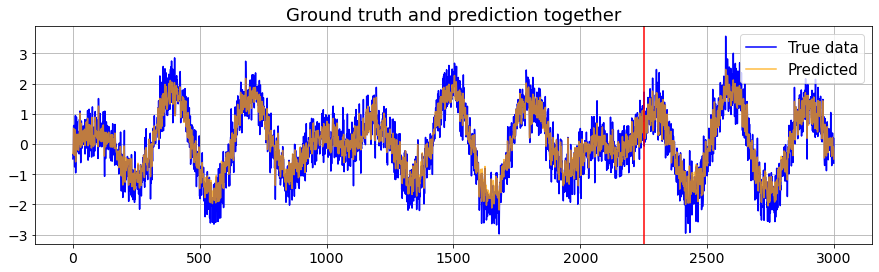


Embedding size: 4
Error (mae): [0.3890435908835886]
----------------------------------------------------------------------------------------------------


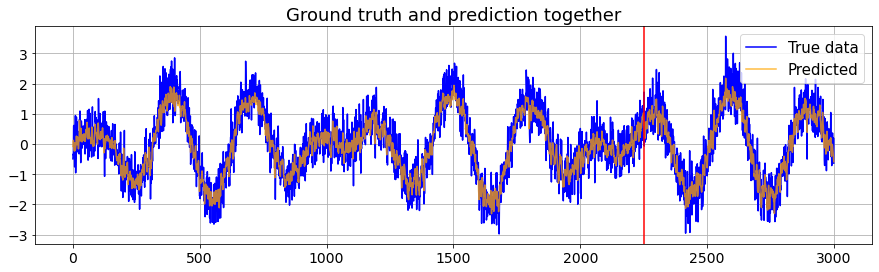


Embedding size: 6
Error (mae): [0.4068539637760611]
----------------------------------------------------------------------------------------------------


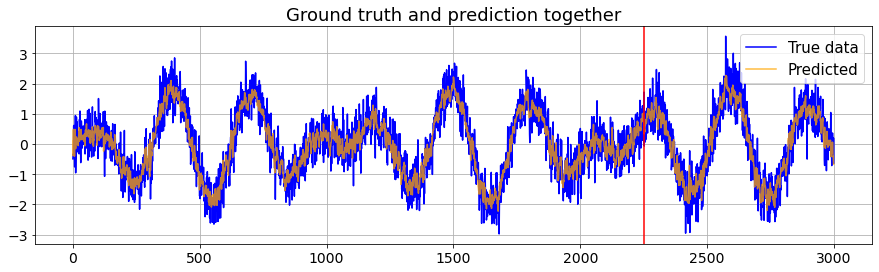


Embedding size: 8
Error (mae): [0.42933271525524225]
----------------------------------------------------------------------------------------------------


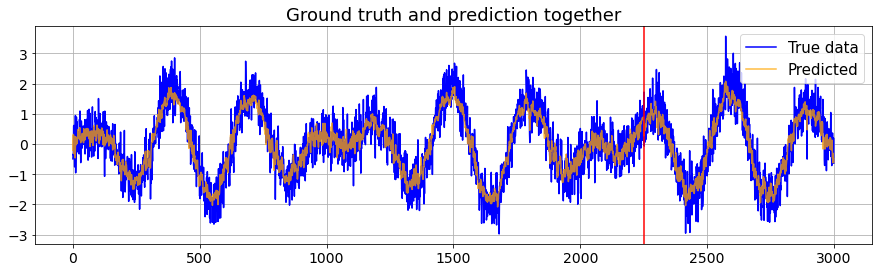


Embedding size: 10
Error (mae): [0.4539815574701413]
----------------------------------------------------------------------------------------------------


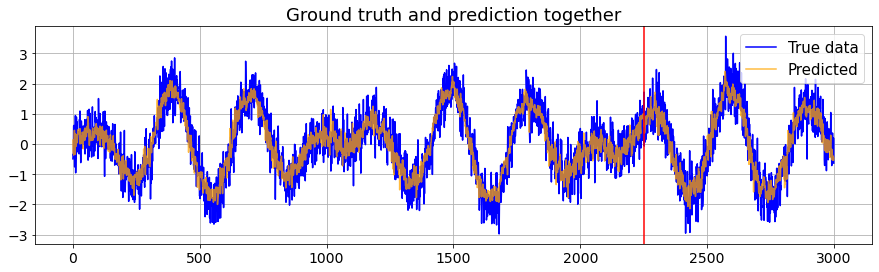


Embedding size: 12
Error (mae): [0.4808317556619896]
----------------------------------------------------------------------------------------------------


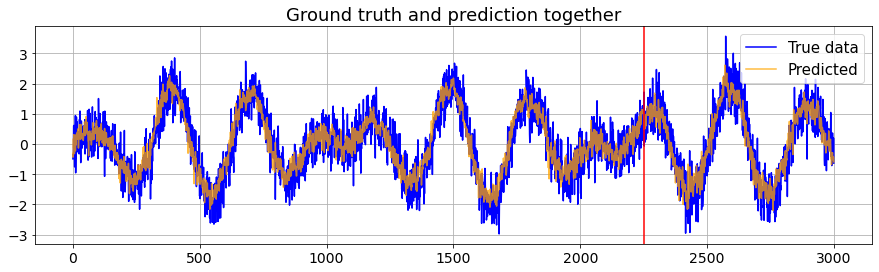

In [39]:
for s in [2,4,6,8,10,12]:  # s = steps  - tamaño ventana
    trainX,testX,trainY,testY = prepare_data(s)
    model = build_simple_rnn(num_units=32,num_dense=8, embedding=s)
    batch_size=16
    num_epochs = 100
    model.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size,
          verbose=0)
    preds = predictions(model,trainX,testX)
    print("Embedding size: {}".format(s))
    print("Error (mae):", errors(testX, df))
    print("-"*100)
    plot_compare(preds)
    print()

### `El mejor resultado se alcanzó con la ventana de tamaño 2`

### Number of epochs

Ran for 100 epochs
Error: [0.3046463984568894]
----------------------------------------------------------------------------------------------------


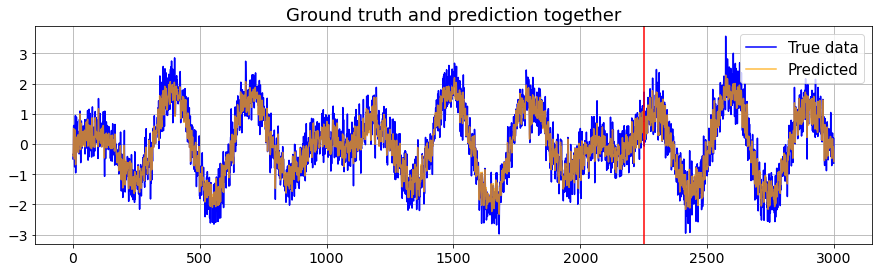


Ran for 200 epochs
Error: [0.29823461848852323]
----------------------------------------------------------------------------------------------------


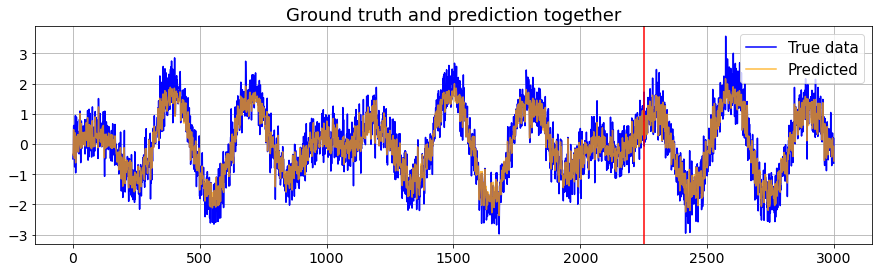


Ran for 300 epochs
Error: [0.2899548076359175]
----------------------------------------------------------------------------------------------------


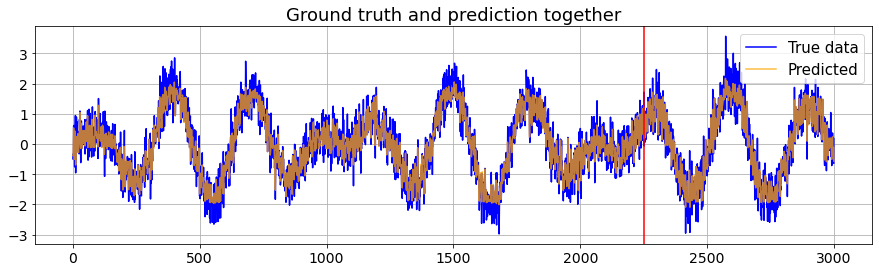


Ran for 400 epochs
Error: [0.32259026947928976]
----------------------------------------------------------------------------------------------------


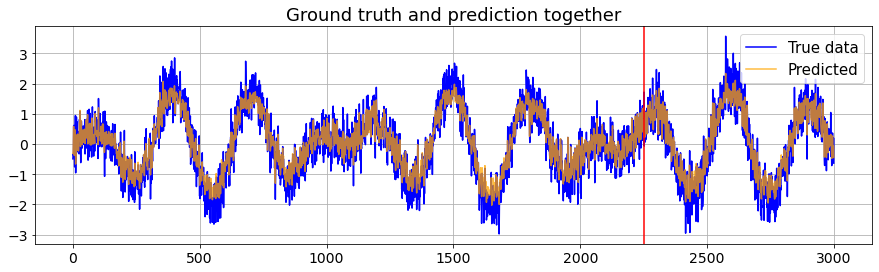


Ran for 500 epochs
Error: [0.30382679472616464]
----------------------------------------------------------------------------------------------------


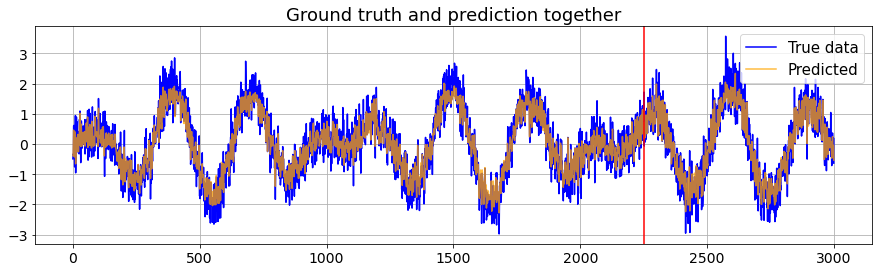

In [40]:
for e in [100,200,300,400,500]:
    trainX, testX, trainY, testY = prepare_data(2)
    model = build_simple_rnn(num_units=32,num_dense=8,embedding=2)
    batch_size=8
    num_epochs = e
    model.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size,
          verbose=0)
    preds = predictions(model,trainX,testX)
    print("Ran for {} epochs".format(e))
    print("Error:", errors(testX, df))
    print("-"*100)
    plot_compare(preds)
    print()

### `El mejor resultado se obtuvo con un epoch  de 100`

### Batch size

Ran with batch size: 2
Error: [0.295405387477919]
----------------------------------------------------------------------------------------------------


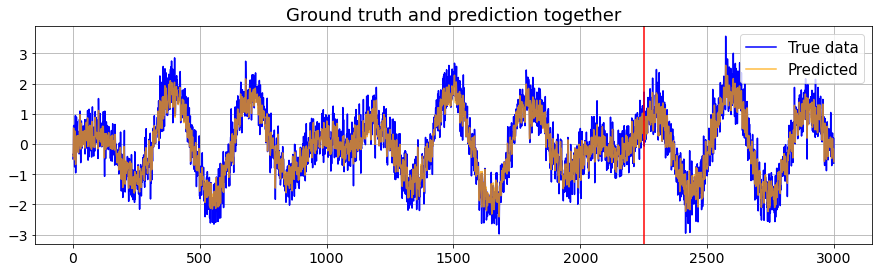


Ran with batch size: 4
Error: [0.330555831948735]
----------------------------------------------------------------------------------------------------


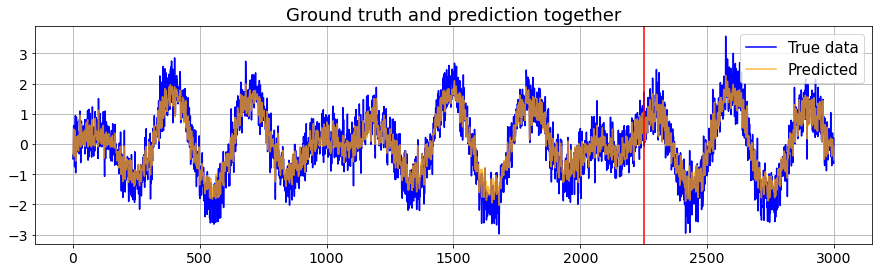


Ran with batch size: 8
Error: [0.29693753145652624]
----------------------------------------------------------------------------------------------------


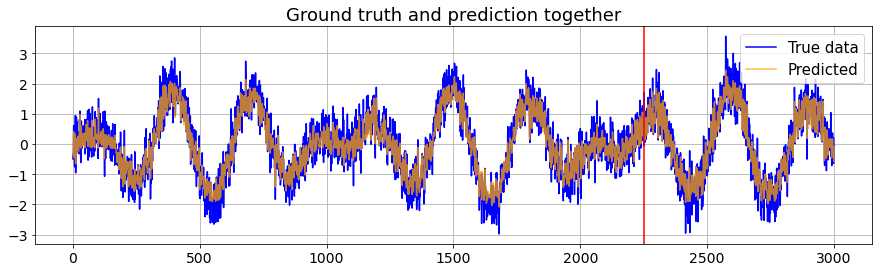


Ran with batch size: 16
Error: [0.32051364673509547]
----------------------------------------------------------------------------------------------------


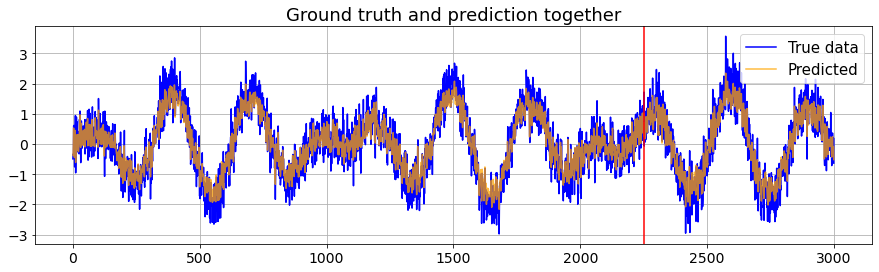


Ran with batch size: 32
Error: [0.2900421942678144]
----------------------------------------------------------------------------------------------------


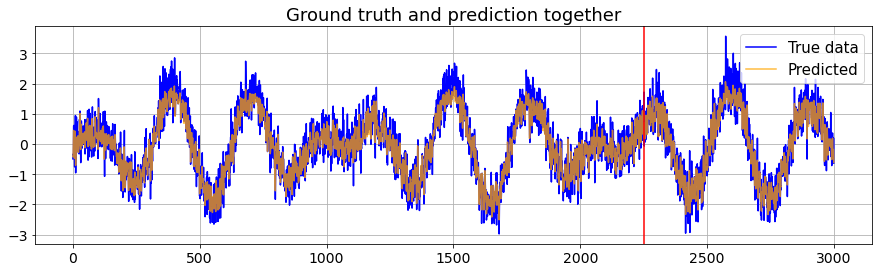


Ran with batch size: 64
Error: [0.3002503987628119]
----------------------------------------------------------------------------------------------------


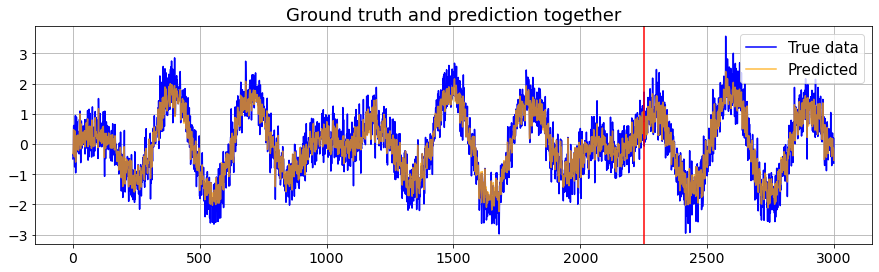

In [41]:
best_step = 2
best_epoch = 100

for b in [2,4,8,16,32,64]:
    trainX,testX,trainY,testY = prepare_data(best_step)
    model = build_simple_rnn(num_units=32,num_dense=8,embedding=best_step)
    batch_size=b
    num_epochs = best_epoch
    model.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size,
          verbose=0)
    preds = predictions(model,trainX,testX)
    print("Ran with batch size: {}".format(b))
    print("Error:", errors(testX, df))
    print("-"*100)
    plot_compare(preds)
    print()

### `EL mejor valor (menor error 0,3012) se obtuvo con batch = 32`

### Summary

Clearly, following trends were observed,

- Too small embedding size is not useful but a very long embedding is also not effective. An embedding of 2 looks good for this data.
- Results with less epochs (100) are  better.
- A batch size of 32  looks optimal for this scenario.
Ultimately, an exhaustive hyperparameter tuning is needed for the best overall performance. Also, the predictive power is not well-defined as we are judging the quality of the prediction mostly visually here but a neumerical metric (or a few of them) would be a better approach.

## ¿Da mejores resultados entrenar el modelo así?
`SI.  Usando un 80% de los datos para entrenar el modelo dió mejor resultado que usar sólo el 25% de los mismos (archivo SimpleRnn-time-series) con el que se había obtenido un 31,25% de error como  mejor resultado. `